### Exercise 9
Simulate different synthetic periodic/aperiodic signals.<br>
• Review time-plot, ACF and auto-covariance plots.<br>
• Compute periodogram and review spectra.<br>
• Repeat exercise with noisy synthetic signals.<br>

Analyze the spectral density of known processes.<br>
• Review how parameters affect the spectral density.<br>
• Integrate the spectral density to confirm it matches the total variance.<br>
• Generate signals and compare periodogram with spectral density.<br>

Study real-world time series.<br>
• Compute periodogram and review spectra.<br>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess


from utils import get_figure, time_plot, acovf_plot, plot_fft, arma_theoretical_spectral_density
from data.ex_data import get_sea_surface_temp

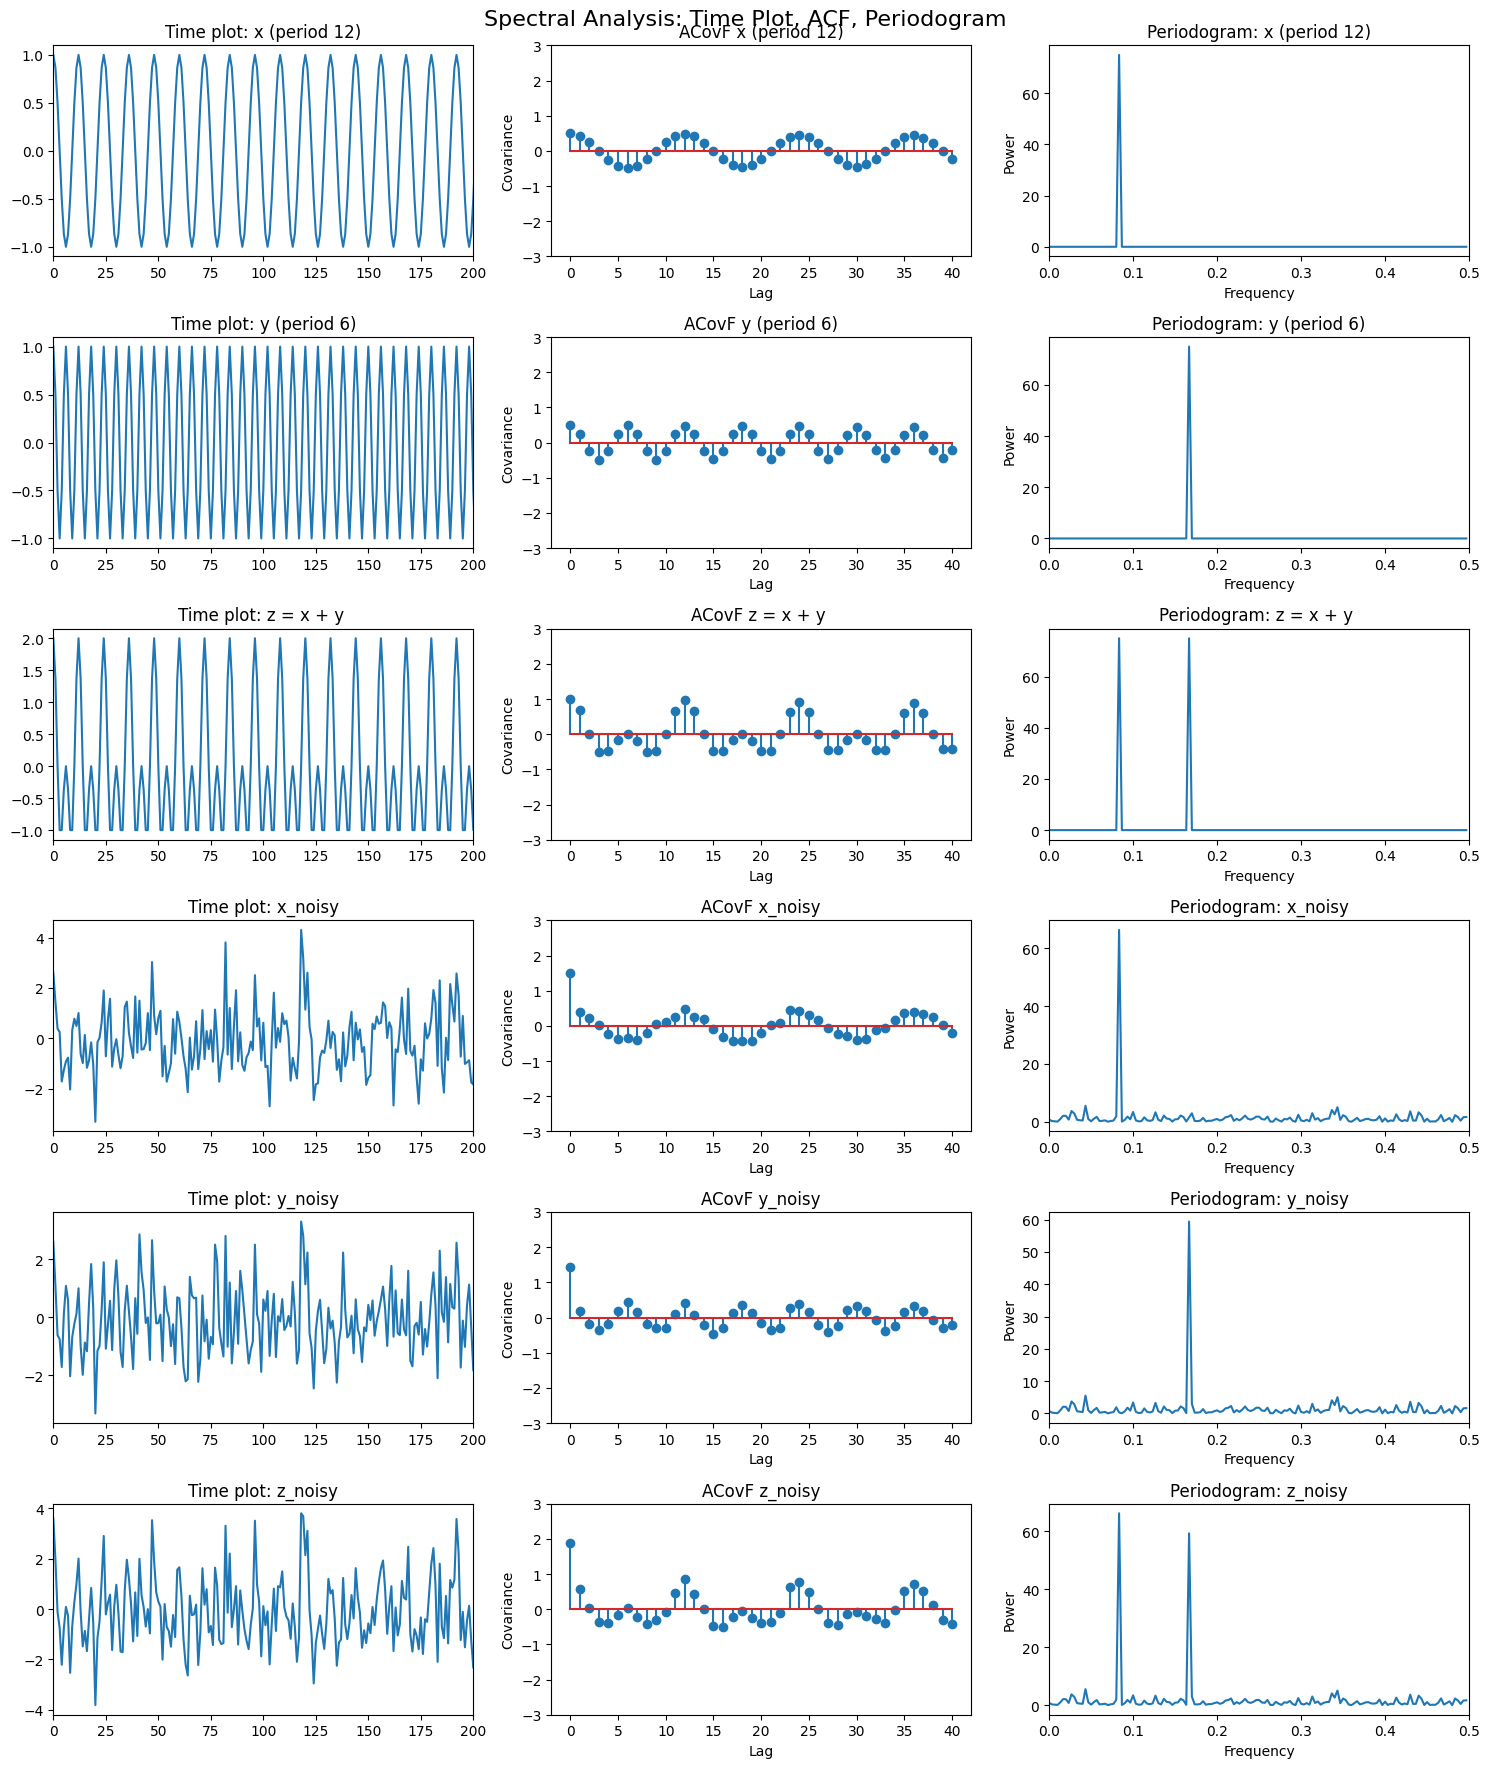

In [11]:

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acovf

def acovf_plot(x, nlags, ax, title=""):
    ac = acovf(x, nlag=nlags, fft=True)
    ax.stem(range(len(ac)), ac)
    ax.set_title(f"ACovF {title}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Covariance")

def periodogram(x):
    n = len(x)
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(n, d=1)   
    P = (1/n) * np.abs(X)**2
    mask = freqs >= 0                
    return freqs[mask], P[mask]

n = 300
t = np.arange(n)


# Periodic signals
x = np.cos(2 * np.pi * t / 12)        # period = 12
y = np.cos(2 * np.pi * t / 6)         # period = 6
z = x + y                             

noise = np.random.normal(scale=1, size=n)
x_noisy = x + noise
y_noisy = y + noise
z_noisy = z + noise

signals = [
    (x, "x (period 12)"),
    (y, "y (period 6)"),
    (z, "z = x + y "),
    (x_noisy, "x_noisy"),
    (y_noisy, "y_noisy"),
    (z_noisy, "z_noisy"),
]


fig, axs = plt.subplots(len(signals), 3, figsize=(15, 18))
fig.suptitle("Spectral Analysis: Time Plot, ACF, Periodogram", fontsize=16)

for i, (signal, name) in enumerate(signals):

    #time plot 
    axs[i, 0].plot(t, signal)
    axs[i, 0].set_title(f"Time plot: {name}")
    axs[i, 0].set_xlim(0, 200)

    #autocovariance
    acovf_plot(signal, nlags=40, ax=axs[i, 1], title=name)
    axs[i, 1].set_ylim(-3, 3)

    #periodogram
    f, P = periodogram(signal)
    axs[i, 2].plot(f, P)
    axs[i, 2].set_title(f"Periodogram: {name}")
    axs[i, 2].set_xlim(0, 0.5)
    axs[i, 2].set_xlabel("Frequency")
    axs[i, 2].set_ylabel("Power")

plt.tight_layout()
plt.show()

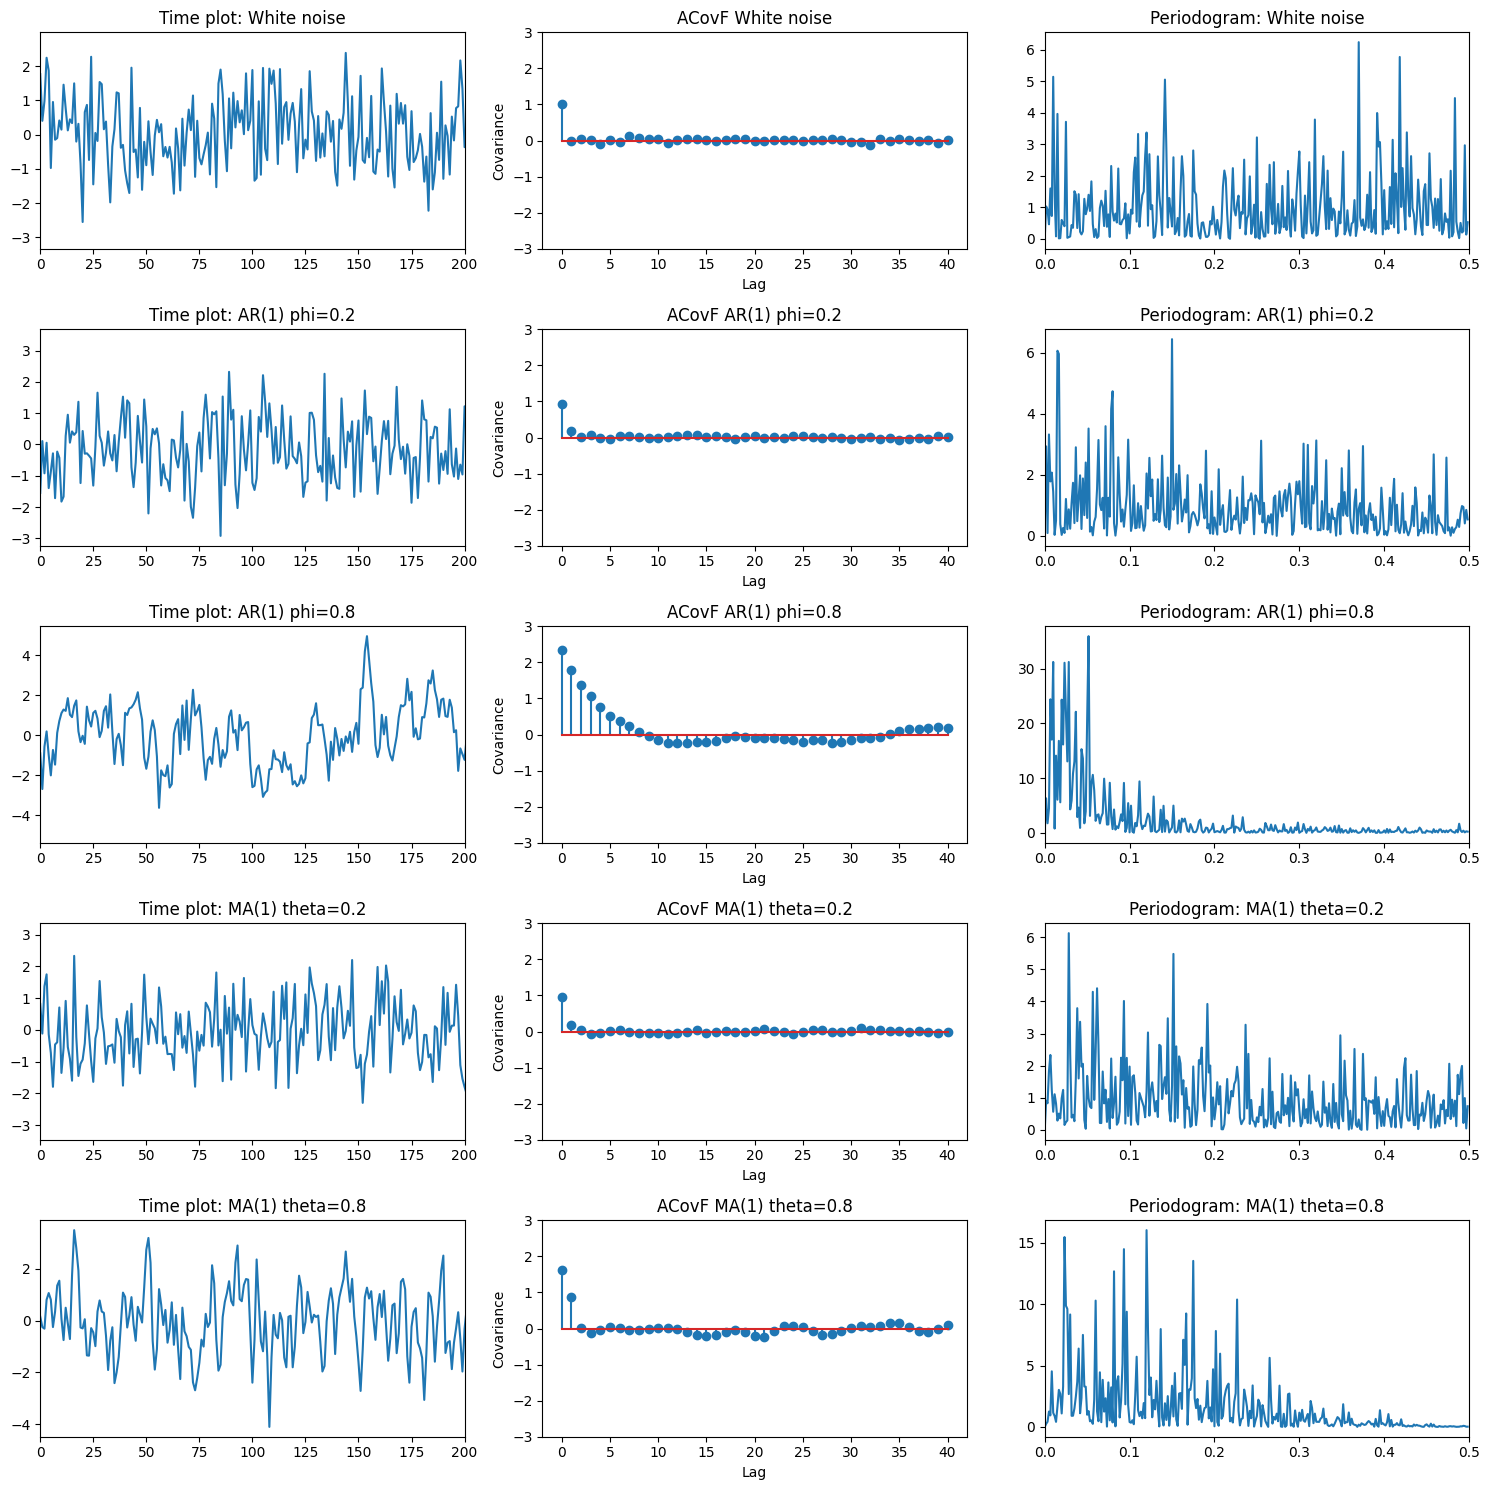

In [10]:
# --- Aperiodic synthetic signals: white noise, AR(1), MA(1) ---
np.random.seed(0)
n = 600
t = np.arange(n)

aperiodic = []

# White noise
wn = np.random.normal(0, 1, size=n)
aperiodic.append((wn, "White noise"))

# AR(1)
for phi in [0.2, 0.8]:
    model = ArmaProcess(ar=np.array([1, -phi]), ma=np.array([1]))
    x_ar = model.generate_sample(nsample=n, scale=1.0)
    aperiodic.append((x_ar, f"AR(1) phi={phi}"))

# MA(1)
for theta in [0.2, 0.8]:
    model = ArmaProcess(ar=np.array([1]), ma=np.array([1, theta]))
    x_ma = model.generate_sample(nsample=n, scale=1.0)
    aperiodic.append((x_ma, f"MA(1) theta={theta}"))

fig, axs = plt.subplots(len(aperiodic), 3, figsize=(15, 3*len(aperiodic)))
for i, (s, name) in enumerate(aperiodic):
    axs[i,0].plot(s); axs[i,0].set_title(f"Time plot: {name}"); axs[i,0].set_xlim(0, 200)
    acovf_plot(s, nlags=40, ax=axs[i,1], title=name); axs[i,1].set_ylim(-3, 3)
    f, P = periodogram(s - np.mean(s))
    axs[i,2].plot(f, P); axs[i,2].set_title(f"Periodogram: {name}"); axs[i,2].set_xlim(0, 0.5)
plt.tight_layout()
plt.show()


### Aperiodic synthetic signals

- **White noise** looks completely random in the time plot. The autocovariance is only large at lag 0, and the periodogram is flat, meaning all frequencies are equally important.

- **AR(1) with small φ (0.2)** shows only a little dependence over time. The autocovariance drops quickly, and the periodogram has slightly more power at low frequencies.

- **AR(1) with large φ (0.8)** changes more slowly over time. The autocovariance decreases slowly, and the periodogram has a strong peak at low frequencies, showing long-term dependence.

- **MA(1) with small θ (0.2)** looks similar to white noise. Only the first lag in the autocovariance is noticeable, and the periodogram is almost flat.

- **MA(1) with large θ (0.8)** has stronger short-term effects. This appears as a bigger spike at lag 1 in the autocovariance and more variation in the periodogram, but without strong low-frequency dominance.

In short, AR models mainly affect long-term behavior, MA models affect short-term behavior, and white noise has no structure.


In [12]:
def integrate_sd(freq, f):
    # use symmetry of the spectral density
    return 2 * np.trapz(f, freq)

sigma = 1.0
freq = np.linspace(0, 0.5, 5000)

# MA(1)
for theta in [0.2, 0.8]:
    f_ma = sigma**2 * (1 + theta**2 + 2*theta*np.cos(2*np.pi*freq))
    print(
        f"MA(1) theta={theta}:",
        "integral =", round(integrate_sd(freq, f_ma), 3),
        "theory =", round(sigma**2 * (1 + theta**2), 3),
    )

# AR(1)
for phi in [0.2, 0.8]:
    f_ar = sigma**2 / (1 - 2*phi*np.cos(2*np.pi*freq) + phi**2)
    print(
        f"AR(1) phi={phi}:",
        "integral =", round(integrate_sd(freq, f_ar), 3),
        "theory =", round(sigma**2 / (1 - phi**2), 3),
    )


MA(1) theta=0.2: integral = 1.04 theory = 1.04
MA(1) theta=0.8: integral = 1.64 theory = 1.64
AR(1) phi=0.2: integral = 1.042 theory = 1.042
AR(1) phi=0.8: integral = 2.778 theory = 2.778


/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_91818/1518850482.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 2 * np.trapz(f, freq)


The numerical integral of the spectral density is very close to the theoretical variance, confirming that the total power in the frequency domain equals the variance in the time domain.

# Compare periodogram with spectral density

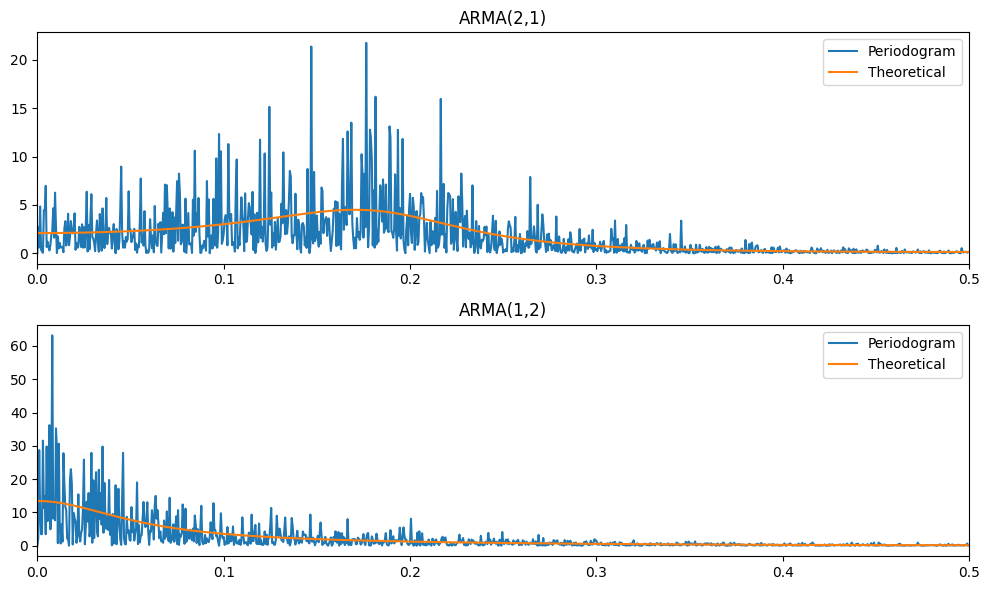

In [13]:
np.random.seed(42)
n = 2000
freq = np.linspace(0, 0.5, 1000)

configs = [
    ([0.5, -0.4], [0.3], "ARMA(2,1)"),
    ([0.7], [0.2, -0.1], "ARMA(1,2)"),
]

fig, axs = plt.subplots(len(configs), 1, figsize=(10, 6))

for ax, (phi, theta, label) in zip(np.atleast_1d(axs), configs):
    model = ArmaProcess(ar=np.r_[1, -np.array(phi)], ma=np.r_[1, np.array(theta)])
    x = model.generate_sample(nsample=n)

    f_hat, P = periodogram(x - x.mean())
    f_theory = arma_theoretical_spectral_density(freq, sigma=1.0, phi=phi, theta=theta)

    ax.plot(f_hat, P, label="Periodogram")
    ax.plot(freq, f_theory, label="Theoretical")
    ax.set_title(label)
    ax.set_xlim(0, 0.5)
    ax.legend()

plt.tight_layout()
plt.show()


The blue curve (periodogram) is noisy because it is computed from a single, finite time series. The orange curve (theoretical spectral density) is smooth and represents the true average distribution of power across frequencies.

For the **ARMA(2,1)** process, most power is concentrated at low to mid frequencies, and the periodogram fluctuates around the theoretical curve.  
For the **ARMA(1,2)** process, power is mainly concentrated at very low frequencies, leading to large spikes near zero frequency in the periodogram.

Overall, the periodogram follows the shape of the theoretical spectral density but with strong variability, confirming that the periodogram is a rough estimator of the true spectral density.


### Compute periodogram for real-world SST dataset: Sea surface temperature

/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_37007/1387103665.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim(0, P.max() * 1.1)


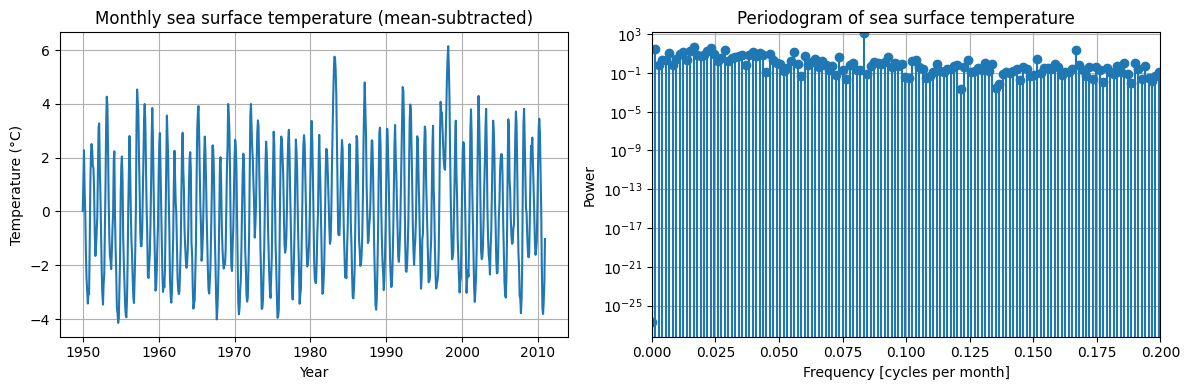

In [ ]:
df = get_sea_surface_temp()
df = df.set_index("DATE").sort_index()

series = df["value"].asfreq("MS")

x = series - series.mean()

n = len(x)
X = np.fft.fft(x.values)
freqs = np.fft.fftfreq(n, d=1) 

# positive frequencies only
mask = freqs >= 0
freqs_pos = freqs[mask]
P = (1/n) * (np.abs(X[mask])**2)  

fig, axs = get_figure(ncols=2, figsize=(12,4))

# time plot
time_plot(
    x=x.index, 
    y=x,
    ax=axs[0],
    title="Monthly sea surface temperature (mean-subtracted)",
    xlabel="Year",
    ylabel="Temperature (°C)"
)

# periodogram 
axs[1].stem(freqs_pos, P, basefmt=" ") 
axs[1].set_title("Periodogram of sea surface temperature")
axs[1].set_xlabel("Frequency [cycles per month]")
axs[1].set_ylabel("Power")

axs[1].set_xlim(0, 0.2)
axs[1].set_yscale("log")
axs[1].set_ylim(0, P.max() * 1.1)

fig.tight_layout()


The time plot shows a strong and regular yearly pattern in the sea surface temperature after removing the mean, together with some irregular fluctuations over time.

The periodogram shows a clear peak at a frequency of about 1/12 cycles per month, which corresponds to the annual seasonal cycle. Other frequencies have much lower power, indicating that most of the variability is driven by this seasonal pattern, with the remaining power coming from noise and longer-term variability.

### Compare clean vs noisy periodogramm

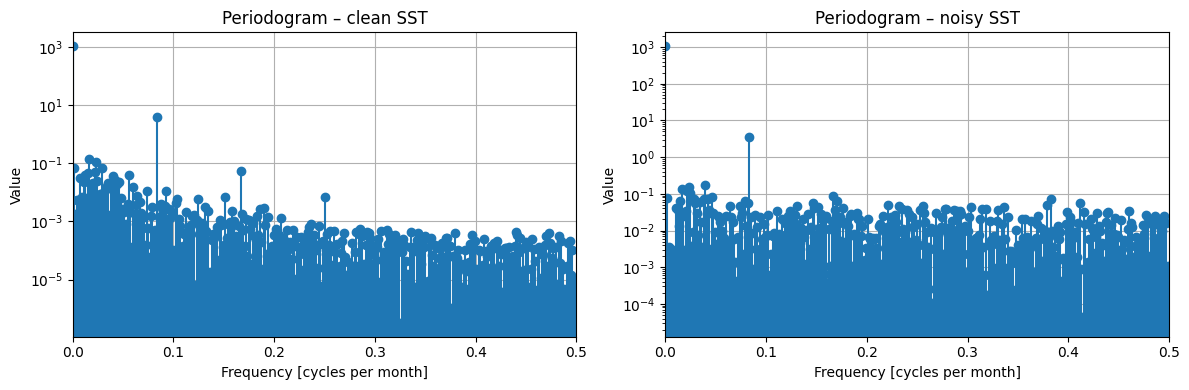

In [ ]:

rng = np.random.default_rng(42)
noise = rng.normal(loc=0.0, scale=series.std(), size=len(series))
series_noisy = series + noise

fig, axs = get_figure(ncols=2, figsize=(12, 4))

#clean
plot_fft(
    axs[0],
    series,
    periodogram=True,
    sample_spacing_name="month"
)
axs[0].set_title("Periodogram – clean SST")
axs[0].set_xlim(0, 0.5)
axs[0].set_yscale("log")

#noisy
plot_fft(
    axs[1],
    series_noisy,
    periodogram=True,
    sample_spacing_name="month"
)
axs[1].set_title("Periodogram – noisy SST")
axs[1].set_xlim(0, 0.5)
axs[1].set_yscale("log")

fig.tight_layout()


In the clean SST periodogram, a clear peak appears at about 1/12 cycles per month, showing the strong yearly seasonal pattern in sea surface temperature.

After adding noise, the overall power level increases and the spectrum becomes noisier, but the main seasonal peak is still visible. This shows that noise spreads power across many frequencies, while the dominant seasonal signal remains.
